In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U accelerate
!pip install -q -U transformers
!pip install phik
!pip install seaborn 
!pip install -U scikit-learn

!pip3 install optimum>=1.12.0
!pip3 install auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/  # Use cu117 if on CUDA 11.7

In [1]:
import torch
import os
import re
import warnings
import phik
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from typing import Union
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [2]:
sns.set_style("whitegrid")

In [3]:
# Check if cuda is available
assert torch.cuda.is_available(), "Cuda is not available, you cannot use the quantized version of the Mistral model without a GPU!"

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"All calculations will be performed on {device}")

All calculations will be performed on cuda


In [5]:
# from huggingface_hub import notebook_login
# notebook_login()

In [81]:
class TmEval:
    def __init__(
            self,
            model_name: str,
            quantization_mode: Union[str, bool] = False,  # Only for Mistral
            device: str = 'cpu'
        ):

        if isinstance(quantization_mode, str):
            assert device == 'cuda', 'If you want to use quantization mode for your LLM, please, provide GPU'
        self.device = device

        # Load Model
        self.model = self.__set_model(quantization_mode, model_name)
        # Load tokenizer
        self.tokenizer = self.__set_tokenizer(model_name)

    def __set_model(self, quantization_mode, model_name):
        if quantization_mode == 'nf4':
            # Qunatization config
            quantization_config_4bit = BitsAndBytesConfig(
                load_in_4bit = True,  # enable 4-bit quantization
                bnb_4bit_quant_type = 'nf4',  # information theoretically optimal dtype for normally distributed weights
                bnb_4bit_use_double_quant = True,  # quantize quantized weights
                bnb_4bit_compute_dtype = torch.bfloat16  # optimized fp format for ML
            )

            return AutoModelForCausalLM.from_pretrained(
                model_name,
                quantization_config=quantization_config_4bit
            )
        else:
            return AutoModelForCausalLM.from_pretrained(
                model_name,
                device_map=self.device,
                trust_remote_code=False,
                revision="main"
            )

    def __set_tokenizer(self, model_name):
        return AutoTokenizer.from_pretrained(model_name)

    def get_dataset_size(self):
        return self.data.shape[0]

    def generate_answer(self, prompt, temp, n_token):
        torch.cuda.empty_cache()
        encoded = self.tokenizer(prompt, return_tensors="pt", add_special_tokens=False)
        model_input = encoded
        model_input = model_input.to(self.device)
        if self.device=='cpu':
            self.model.to(self.device)
        generated_ids = self.model.generate(
            **model_input, do_sample=True,
            max_new_tokens=n_token,
            temperature=temp,
            num_return_sequences=1,
            pad_token_id=self.tokenizer.eos_token_id
            )
        decoded = self.tokenizer.batch_decode(generated_ids)
        return decoded

    def extract_substring(self, input_string):
        index = input_string.find("[/INST]")
        if index != -1:
            return input_string[index + len("[/INST]"):]
        else:
            return ""

    def get_answer(
            self,
            temp=0.1,
            n_token=500,
            instruction='',
            sample='',
            use_system_tokens=True,
            print_prompt=False,
            system_prompt=""
        ):
        """
        Get result of the inference for one sample.

        Parameters
        ----------
        temp : float, default=0.1
            The value used to modulate the next token probabilities.
        n_token : int, default=500
            The maximum numbers of tokens to generate, ignoring the number of tokens in the prompt.
        instruction : str
            The instruction part of the prompt.
        sample : str
            The wordset
        use_system_tokens : bool, dafault=True
            If True, then special tokens will be used.
        print_prompt : bool, default=False
            Print the generated prompt.
        system_prompt : str
            Use system prompt (please, use this prompt for Llama model!).

        Returns
        -------
        result : str
            Generated response.
        """

        # Construct prompt
        if use_system_tokens:
            model_name = self.model.config._name_or_path.lower()
            pattern = r"(mistral|llama|gpt)"
            model_name = re.findall(pattern, model_name)[0]

            if model_name == "mistral":
                prompt = f"<s> [INST] {instruction} {sample} [/INST]"
            elif model_name == "llama":
                if len(system_prompt) == 0:
                    prompt = f"<s> [INST] {instruction}{sample}[/INST]"
                else:
                    prompt = f"<s> [INST] <<SYS>> {system_prompt} <</SYS>> {instruction} {sample} [/INST]"
            elif model_name == "gpt":
                print("There is no system token for GPT. The 'without using system tokens' mode is enabled. Internal algorithms for postprocessing and calculation of metrics can give unstable results")
                prompt = f"{instruction}\n{sample}"
        else:
            warnings.warn("""The "without using system tokens" mode is enabled. Internal algorithms for postprocessing and calculation of metrics can give unstable results""")
            prompt = f"{instruction}\n{sample}"

        if print_prompt:
            print(prompt)

        # Generate answer
        answer = self.generate_answer(prompt, temp, n_token)

        # Extract the result
        if use_system_tokens:
            result = self.extract_substring(answer[0])
        else:
            result = answer[0]
        return result.replace("\n", " ")

    def get_prompt(self, prompt_type, sample):
        try:
            prompt_type is not None
        except:
            print("Please, provide the type of the internal prompt or ")
        system_prompt = ''
        instruction = ''
        if prompt_type == "P1_Mistral":
            instruction = ("You are a useful assistant who evaluates the coherence of words.\n"
                    "You will receive a list of words, please determine which class the given "
                    "list of words belongs to by answering the question: 'Is it possible to determine "
                    "a common topic for the presented word set or at least for the most part of the set?'."
                    "Classification rules: yes - if words have a strong connection between them, "
                    "rather yes - if some words are too common or out of topic, "
                    "rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics, "
                    "no - when words seem to be unconnected, "
                    "neutral - if it is hard for you to answer on the question.\nPrint only class without explanation and additional information.\n")

            sample = 'Words: ' + sample + "\nClass:"
        elif prompt_type == "P1_Llama":
            system_prompt = "You are a useful assistant who evaluates the coherence of words."
            instruction = ("You will receive a list of words, please determine which class the given "
                    "list of words belongs to by answering the question: 'Is it possible to determine "
                    "a common topic for the presented word set or at least for the most part of the set?'."
                    "Classification rules: yes - if words have a strong connection between them, "
                    "rather yes - if some words are too common or out of topic, "
                    "rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics, "
                    "no - when words seem to be unconnected, "
                    "neutral - if it is hard for you to answer on the question.\nPrint only class without explanation and additional information.\n")

            sample = 'Words: ' + sample + "\nClass:"
        elif prompt_type == "C2_Llama":
            system_prompt = ""
            instruction = ("You are the assistant for text classification. You will receive a TEXT, and you should answer 'YES' or 'NO' to the question: "
                           "'Is it possible to determine a common topic for the TEXT or at least for the most part of the TEXT?'. "
                           "Please, make sure you to only return YES or NO and nothing more.\n")
            sample = "TEXT: " + sample + "\nANSWER: "

        return system_prompt, instruction, sample

    def get_results(
            self,
            data,
            filename,
            num_iter,
            base_dir,
            temp=0.1,
            prompt_type=None,
            n_token=500,
            remove_old_file=True,
            print_info=False,
            use_system_tokens=True,
            save_results_to_df=False
        ):
        """
        Get inference on the dataset.

        Parameters
        ----------
        data : pd.DataFrame
            Input dataset.
        filename : str
            The file where the results of the generation will be recorded.
        num_iter : int
            The number of samples.
        temp : float, default=0.1
            The value used to modulate the next token probabilities.
        prompt_type : None, str, default=None
            The type of the standard prompt.
        n_token : int, default=500
            The maximum numbers of tokens to generate, ignoring the number of tokens in the prompt.
        remove_old_file : bool, default=True
            If True, then an old file with results will be removed.
        print_info : bool, default=False
            Print the generated prompt and the result of the inference.
        use_system_tokens : bool, default=True
            If True, then special tokens will be used.
        save_results_to_df : bool, default=False
            Save the results of the inference to the dataframe.
        """

        # Check if the columns of the dataset have appropriate names
        try:
            data[["task", "agg_label"]]
        except:
            print("There are no 'task' and 'agg_label' columns in the dataset!")

        # Create file
        data_dir = base_dir.joinpath('data/results')
        res_file = data_dir.joinpath(filename)

        # Remove old file
        if remove_old_file:
            if os.path.exists(res_file):
                os.remove(res_file)

        model_lst = []
        true_lst = []
        wordset_lst = []
        for i in tqdm(range(num_iter)):
            sample = data.iloc[i]["task"]

            system_prompt, instruction, sample = self.get_prompt(prompt_type, sample)

            res_true = data.iloc[i]["agg_label"]
            res_model = self.get_answer(
                temp=temp,
                n_token=n_token,
                instruction=instruction,
                sample=sample,
                use_system_tokens=True,
                print_prompt=print_info,
                system_prompt=system_prompt
            )
            if print_info:
                print(res_model)

            with open(res_file, 'a') as file:
                file.write(f"{data.iloc[i]['task']}\t{res_true}\t{res_model}\n")

            if save_results_to_df:
                model_lst.append(res_model)
                true_lst.append(res_true)
                wordset_lst.append(data.iloc[i]["task"])

        print(f"\nAll results were saved to the {res_file} file.")
        if save_results_to_df:
            print("All results were saved to the dataframe")
            data_res = pd.DataFrame({
                "task": wordset_lst,
                "true": true_lst,
                "model": model_lst}
            )
            return data_res

    def num_to_words(x):
        class_labels = {
            -2: 'bad',
            -1: 'rather_bad',
            0: 'neutral',
            1: 'rather_good',
            2: 'good'}

        return class_labels[x]

    def words_to_num(x):
        class_labels = {
            'bad': -2,
            'rather_bad': -1,
            'neutral': 0,
            'rather_good': 1,
            'good': 2
        }
        return class_labels[x]

    @classmethod
    def extract_answer(cls, input_string, num_class):
        # Lowercase
        res_answer = input_string.lower()
        # Remove extra spaces
        res_answer = res_answer.strip()

        if num_class == 2:
            res = re.findall(r'\b\w*\s*(yes|no)\s*\w*\b', res_answer)
        elif num_class == 4:
            res = re.findall(r'\b\w*\s*(rather yes|rather no)\s*\w*\b', res_answer)
            if len(res) == 0:
                res = re.findall(r'\b\w*\s*(yes|no)\s*\w*\b', res_answer)
        elif num_class == 5:
            res = re.findall(r'\b\w*\s*(rather yes|rather no)\s*\w*\b', res_answer)
            if len(res) == 0:
                res = re.findall(r'\b\w*\s*(yes|no)\s*\w*\b', res_answer)
            if len(res) == 0:
                res = re.findall(r'\b\w*\s*(neutral)\s*\w*\b', res_answer)

        res_answer = "None" if len(res) == 0 else res[0]

        match_map = {
            "None": None,
            "no": -2,
            "rather no": -1,
            "neutral": 0,
            "rather yes": 1,
            "yes": 2
        }

        res_answer = match_map[res_answer]

        return res_answer

    @classmethod
    def postprocess_results(cls, data, answer_type="", num_class=5):
        # Check if there is the column named "model"
        try:
            data["model"]
        except:
            print("There is no 'model' column in the dataset!")

        data["model_extracted"] = [cls.extract_answer(x, num_class) for x in data["model"]]
        
        # Check if there are NaNs in the dataframe
        if np.isnan(data["model_extracted"].unique()).any():
            none_wordsets = data[np.isnan(data["model_extracted"])]["task"]
            print("The number of samples in the results dataset with 'None' extracted answer:", none_wordsets.shape[0])

            for wordset in none_wordsets:
                print("Wordset:", wordset)
                print("Model answer:", data[data["task"] == wordset]["model"].item())
                print("Extracted answer:", data[data["task"] == wordset]["model_extracted"].item())

            # Remove all samples with "NaN" exatracted answer from the results dataset
            data = data[[not elem for elem in np.isnan(data["model_extracted"])]]
            
        return data

    @classmethod
    def plot_answers_distrib(
            cls,
            data,
            model_name='',
            dataset_name='',
            fig_size=(8, 6),
            container_size=12,
            title_size=15,
            ticks_size=12,
            label_size=12,
            save_dir=None,
            print_plot=True,
            num_class=2
            ):
        df = data[["true", "model_extracted"]]
        df.columns = ["Human", "Model"]

        if not isinstance(df.iloc[0]["Human"], str):
            df["Human"] = df["Human"].map(cls.num_to_words)
        if not isinstance(df.iloc[0]["Model"], str):
            df["Model"] = df["Model"].map(cls.num_to_words)

        df_long = df.melt(var_name='Column', value_name='Response')

        if num_class == 5:
            category_order = ["bad", "rather_bad", "neutral", "rather_good", "good"]
        elif num_class == 4:
            category_order = ["bad", "rather_bad", "rather_good", "good"]
        elif num_class == 2:
            category_order = ["bad", "good"]

        df_long['Response'] = pd.Categorical(df_long['Response'], categories=category_order, ordered=True)

        palette_colors = {"Human": "#3A3875", "Model": "#D366D3"}

        plt.figure(figsize=fig_size)

        ax = sns.histplot(
            data=df_long,
            x='Response',
            hue='Column',
            multiple='dodge',
            shrink=0.8,
            palette=palette_colors,
        )

        for i in ax.containers:
            ax.bar_label(i, fontsize=container_size)

        plt.title(f'Distribution of Human and {model_name} answers. {dataset_name}', fontsize=title_size)

        plt.xticks(fontsize=ticks_size)
        plt.yticks(fontsize=ticks_size)

        ax.set_xlabel('Response', fontsize=label_size)
        ax.set_ylabel('Count', fontsize=label_size)

        if save_dir is not None:
            plt.savefig(save_dir)
            print(f"Plot was saved to the file {save_dir}")

        if print_plot:
            plt.show()
        else:
            plt.close()

    @classmethod
    def plot_conf_matrix(
            cls,
            true,
            predict,
            model_name="",
            heatmap_fontsize=10,
            axis_label_fontsize=13,
            title_fontsize=17,
            ticklabel_fontsize=20,
            save_dir=None,
            print_plot=False,
            num_class=2
        ):

        if isinstance(true[0], str):
            true = [cls.words_to_num(x) for x in true]
        if isinstance(predict[0], str):
            predict = [cls.words_to_num(x) for x in predict]

        cm = confusion_matrix(true, predict)

        class_labels = {
                -2: 'bad',
                -1: 'rather_bad',
                0: 'neutral',
                1: 'rather_good',
                2: 'good'}
        if num_class == 2:
            classes_num = [-2, 2]
        elif num_class == 4:
            classes_num = [-2, -1, 1, 2]
        elif num_class == 5:
            classes_num = [-2, -1, 0, 1, 2]
        sns.heatmap(cm,
                    annot=True,
                    fmt='g',
                    xticklabels=[class_labels[label] for label in classes_num],
                    yticklabels=[class_labels[label] for label in classes_num],
                    annot_kws={"fontsize": heatmap_fontsize}
         )

        plt.ylabel('Actual',fontsize=axis_label_fontsize)
        plt.xlabel('Prediction',fontsize=axis_label_fontsize)
        plt.title(f'Confusion Matrix {model_name}',fontsize=title_fontsize)

        plt.xticks(fontsize=ticklabel_fontsize)
        plt.yticks(fontsize=ticklabel_fontsize)

        if save_dir is not None:
            plt.savefig(save_dir)
            print(f"Plot was saved to the file {save_dir}")

        if print_plot:
            plt.show()
        else:
            plt.close()

    @classmethod
    def calculate_metrics(cls, data, save_dir=None):
        if isinstance(data.iloc[0]["true"], str):
            data["true"] = data["true"].map(cls.words_to_num)
        if isinstance(data.iloc[0]["model_extracted"], str):
            data["model_extracted"] = data[true].map(cls.words_to_num)
        
        # non-linear dependencies
        phik_corr = data[["true", "model_extracted"]].phik_matrix()
        phik_corr = phik_corr.loc["true"]["model_extracted"]

        # linear_correlation
        lin_corr = data[["true", "model_extracted"]].corr()
        lin_corr = lin_corr.loc["true"]["model_extracted"]

        # accuracy
        accuracy = accuracy_score(data["true"], data["model_extracted"])

        # f1-score
        f1_score_res = f1_score(data["true"], data["model_extracted"], average='macro')

        metrics_df = pd.DataFrame(
            {
                "phik": [phik_corr],
                "pearson": [lin_corr],
                "accuracy": [accuracy],
                "f1_score": [f1_score_res]
            }
        )
        if save_dir is not None:
            metrics_df.to_csv(save_dir)

        return metrics_df


## Load the Data

In [7]:
# Read the Data
# Run this cell if you are using Google Colaboratory

# from google.colab import drive
# drive.mount('/content/drive')

# your_path = "ITMO/RW'23/"

# BASE_DIR = Path(f"/content/drive/MyDrive/{your_path}")
# DATA_DIR = BASE_DIR.joinpath("data")  # Please upload the data_quality_estim.csv dataset to the data folder

# FILE_NAME = "words_consistensy_wordset_dataset_agg.csv"

# FILE_QUAL = DATA_DIR.joinpath(FILE_NAME)

In [7]:
# BASE_DIR = Path('Inference_example.ipynb').resolve().parent.parent

DATA_DIR_NAME = 'data'  # Local directory

# DATA_DIR = BASE_DIR.joinpath(DATA_DIR_NAME)
FILE_NAME_QUAL = 'words_consistensy_wordset_dataset_agg.csv'

FILE = f"{DATA_DIR_NAME}/{FILE_NAME_QUAL}"

In [8]:
data_quality = pd.read_csv(FILE)

columns_map = {
    "INPUT:wordset": "task",
    "assessment": "agg_label"
}

data_quality = data_quality.rename(columns=columns_map)

data_quality.head(10)

,task,INPUT:dataset_name,OUTPUT:quality,homogenity,agg_label
0,able amaze fill glad stop daily fantastic move...,amazon_food,"['rather_bad', 'bad', 'rather_bad']",0.7,-1
1,able amaze fill stop glad daily fantastic move...,amazon_food,"['bad', 'rather_good', 'rather_bad', 'rather_b...",0.5,-1
2,able amaze fill stop glad daily fantastic move...,amazon_food,"['bad', 'rather_bad', 'rather_bad']",0.7,-1
3,able amaze glad fill stop fantastic daily move...,amazon_food,"['bad', 'bad', 'bad']",1.0,-2
4,absolute church truth doug scripture symbol li...,20newsgroups,"['rather_good', 'bad', 'bad', 'rather_good', '...",0.6,1
5,absolute church truth mission nasa doug mars e...,20newsgroups,"['rather_bad', 'rather_bad', 'bad', 'rather_ba...",0.8,-1
6,absolute mission church nasa mars earth truth ...,20newsgroups,"['good', 'good', 'bad', 'good', 'good']",0.8,2
7,absolutely fast white rice service noodle terr...,amazon_food,"['rather_bad', 'bad', 'rather_bad', 'good', 'b...",0.5,-1
8,absolutely fast white super service customer r...,amazon_food,"['bad', 'good', 'rather_good', 'rather_good', ...",0.4,2
9,absolutely grain experience soon there's proce...,amazon_food,"['bad', 'bad', 'rather_bad']",0.7,-2


## Examples with Mistral

In [10]:
# Define the parameters
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"
QUANTIZATION_MODE = 'nf4'
DEVICE = 'cuda'

# Initialize the class object
tm_eval = TmEval(
    model_name=MODEL_NAME,
    quantization_mode=QUANTIZATION_MODE,
    device=DEVICE
)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

#### Example for the classification pipeline

In [11]:
dir_path = Path(os.path.dirname(os.path.realpath("Inference_example.ipynb")))
dir_path

PosixPath('/notebooks')

In [12]:
# Launch on the dataset with system tokens and internal prompt
RES_FILE_NAME = "Mistral7B_classification_P1.csv"
PROMPT_TYPE = 'P1_Mistral'

results_df = tm_eval.get_results(
    base_dir=dir_path,
    data=data_quality,
    prompt_type=PROMPT_TYPE,
    filename=RES_FILE_NAME,
    num_iter=100,
    # num_iter=data_quality.shape[0], # Launch on the entire dataset
    temp=0.1,
    n_token=30,
    remove_old_file=True,
    print_info=False,  # Please, set this flag to False then you launch the pipeline on the entire dataset
    save_results_to_df=True,
    use_system_tokens=True
)

# Results postprocessing
tm_eval.postprocess_results(results_df)

# Divide into two datasets
DATASETS_NAME = "datasets_name.csv"
DATASETS_NAME = dir_path.joinpath(f'data/{DATASETS_NAME}')
datasets_name = pd.read_csv(
    DATASETS_NAME,
    sep=",",
    header=0
)
print("Datasets:", list(set(datasets_name["INPUT:dataset_name"])))

# Divide the entire dataset into parts by the dataset name
amazon_food_data = datasets_name[datasets_name["INPUT:dataset_name"]=="amazon_food"]
newsgroups_data = datasets_name[datasets_name["INPUT:dataset_name"]=="20newsgroups"]

amazon_food_texts = amazon_food_data["INPUT:wordset"]
newsgroups_texts = newsgroups_data["INPUT:wordset"]

results_amazon = results_df[results_df["task"].isin(amazon_food_texts)]
results_newsgroups = results_df[results_df["task"].isin(newsgroups_texts)]

# Save all distributions
tm_eval.plot_answers_distrib(
    results_amazon,
    model_name='Mistral 7B Instruct',
    dataset_name='Amazon Food',
    save_dir=dir_path.joinpath('data/results/mistral7B_amazon_distrib.svg'),
    print_plot=False
    )

tm_eval.plot_answers_distrib(
    results_newsgroups,
    model_name='Mistral 7B Instruct',
    dataset_name='20 Newsgroups',
    save_dir=dir_path.joinpath('data/results/mistral7B_newsgroups_distrib.svg'),
    print_plot=False
    )

# Save all confusion matrices
tm_eval.plot_conf_matrix(
    np.array(results_amazon["true"]),
    np.array(results_amazon["model_extracted"]),
    model_name="Mistral 7B, Amazon Food",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=dir_path.joinpath('data/results/mistral7B_amazon_conf_matrix.png'),
    print_plot=False
    )

tm_eval.plot_conf_matrix(
    np.array(results_newsgroups["true"]),
    np.array(results_newsgroups["model_extracted"]),
    model_name="Mistral 7B, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=dir_path.joinpath('data/results/mistral7B_newsgroups_conf_matrix.png'),
    print_plot=False
    )

100%|██████████| 100/100 [03:01<00:00,  1.82s/it]
/tmp/ipykernel_2246/2600758542.py:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Human"] = df["Human"].map(cls.num_to_words)
/tmp/ipykernel_2246/2600758542.py:346: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Model"] = df["Model"].map(cls.num_to_words)
/tmp/ipykernel_2246/2600758542.py:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 


All results were saved to the /notebooks/data/results/Mistral7B_classification_P1.csv file.
All results were saved to the dataframe
Datasets: ['20newsgroups', 'amazon_food']
Plot was saved to the file /notebooks/data/results/mistral7B_amazon_distrib.svg
Plot was saved to the file /notebooks/data/results/mistral7B_newsgroups_distrib.svg
Plot was saved to the file /notebooks/data/results/mistral7B_amazon_conf_matrix.png
Plot was saved to the file /notebooks/data/results/mistral7B_newsgroups_conf_matrix.png


### Step by step pipeline

In [ ]:
# Example of a launch with system tokens (only for one sample)

system_prompt = ("You are a useful assistant who evaluates the coherence of words. "
                 "You will receive a list of words, please determine which class the given "
                 "list of words belongs to by answering the question: 'Is it possible to determine "
                 "a common topic for the presented word set or at least for the most part of the set?'.\n"
                 "Classification rules:\nyes - if words have a strong connection between them\n"
                 "rather yes - if some words are too common or out of topic\n"
                 "rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics\n"
                 "no - when words seem to be unconnected\n"
                 "neutral - if it is hard for you to answer on the question.\nPrint only class without explanation and additional information.\n")

sample = 'Words: ' + data_quality.iloc[0]["task"] + "\nClass:"

tm_eval.get_answer(
    instruction=system_prompt,
    sample=sample,
    n_token=10,
    use_system_tokens=True,
    print_prompt=True
)

### Example with internal prompt

In [17]:
# Example of the launch on the dataset with system tokens and internal prompt
dir_path = Path(os.path.dirname(os.path.realpath("Inference_example.ipynb")))

RES_FILE_NAME = "example.csv"
PROMPT_TYPE = 'P1_Mistral'

results_df = tm_eval.get_results(
    base_dir=dir_path,
    data=data_quality,
    prompt_type=PROMPT_TYPE,
    filename=RES_FILE_NAME,
    # num_iter=data_quality.shape[0], # Launch on the entire dataset
    num_iter=5,
    temp=0.1,
    n_token=30,
    remove_old_file=True,
    print_info=True,  # Please, set this flag to False then you launch the pipeline on the entire dataset
    save_results_to_df=True
)

  0%|          | 0/5 [00:00<?, ?it/s]

<s> [INST] You are a useful assistant who evaluates the coherence of words.
You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'.Classification rules: yes - if words have a strong connection between them, rather yes - if some words are too common or out of topic, rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics, no - when words seem to be unconnected, neutral - if it is hard for you to answer on the question.
Print only class without explanation and additional information.
 Words: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
Class: [/INST]


 20%|██        | 1/5 [00:01<00:06,  1.54s/it]

 neutral</s>
<s> [INST] You are a useful assistant who evaluates the coherence of words.
You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'.Classification rules: yes - if words have a strong connection between them, rather yes - if some words are too common or out of topic, rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics, no - when words seem to be unconnected, neutral - if it is hard for you to answer on the question.
Print only class without explanation and additional information.
 Words: able amaze fill stop glad daily fantastic move plenty prime empty job subtle strongly litter
Class: [/INST]


 40%|████      | 2/5 [00:02<00:04,  1.48s/it]

 neutral</s>
<s> [INST] You are a useful assistant who evaluates the coherence of words.
You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'.Classification rules: yes - if words have a strong connection between them, rather yes - if some words are too common or out of topic, rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics, no - when words seem to be unconnected, neutral - if it is hard for you to answer on the question.
Print only class without explanation and additional information.
 Words: able amaze fill stop glad daily fantastic move plenty prime empty subtle job strongly litter
Class: [/INST]


 60%|██████    | 3/5 [00:04<00:02,  1.47s/it]

 neutral</s>
<s> [INST] You are a useful assistant who evaluates the coherence of words.
You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'.Classification rules: yes - if words have a strong connection between them, rather yes - if some words are too common or out of topic, rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics, no - when words seem to be unconnected, neutral - if it is hard for you to answer on the question.
Print only class without explanation and additional information.
 Words: able amaze glad fill stop fantastic daily move prime empty plenty subtle job strongly litter
Class: [/INST]


 80%|████████  | 4/5 [00:05<00:01,  1.46s/it]

 neutral</s>
<s> [INST] You are a useful assistant who evaluates the coherence of words.
You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'.Classification rules: yes - if words have a strong connection between them, rather yes - if some words are too common or out of topic, rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics, no - when words seem to be unconnected, neutral - if it is hard for you to answer on the question.
Print only class without explanation and additional information.
 Words: absolute church truth doug scripture symbol libxmu font bible free undefined type motif error application
Class: [/INST]


100%|██████████| 5/5 [00:07<00:00,  1.47s/it]

 neutral</s>

All results were saved to the /notebooks/data/results/example.csv file.
All results were saved to the dataframe


In [18]:
results_df

,task,true,model
0,able amaze fill glad stop daily fantastic move...,-1,neutral</s>
1,able amaze fill stop glad daily fantastic move...,-1,neutral</s>
2,able amaze fill stop glad daily fantastic move...,-1,neutral</s>
3,able amaze glad fill stop fantastic daily move...,-2,neutral</s>
4,absolute church truth doug scripture symbol li...,1,neutral</s>


#### Postprocessing
To demonstrate this stage, we will upload the old results

In [20]:
PROMPT_MISTRAL = "text_coherence_mistral_7b_4_bit_5classes_P2.csv"
RESULTS_DIR = "data/results"
FILE_RESULTS = f"{RESULTS_DIR}/{PROMPT_MISTRAL}"

results_df = pd.read_csv(FILE_RESULTS, sep="\t", names=["task", "true", "model"], header=None)

In [21]:
results_df.head(10)

,task,true,model
0,able amaze fill glad stop daily fantastic move...,-1,neutral</s>
1,able amaze fill stop glad daily fantastic move...,-1,neutral</s>
2,able amaze fill stop glad daily fantastic move...,-1,neutral</s>
3,able amaze glad fill stop fantastic daily move...,-2,neutral</s>
4,absolute church truth doug scripture symbol li...,1,neutral</s>
5,absolute church truth mission nasa doug mars e...,-1,neutral</s>
6,absolute mission church nasa mars earth truth ...,2,rather yes. The words have some connection to...
7,absolutely fast white rice service noodle terr...,-1,rather yes</s>
8,absolutely fast white super service customer r...,2,rather no.</s>
9,absolutely grain experience soon there's proce...,-2,neutral</s>


In [22]:
tm_eval.postprocess_results(results_df)

/tmp/ipykernel_1443/2485555238.py:314: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'None' in (data["model_extracted"].unique()):


In [25]:
# Divide into two datasets
DATASETS_NAME = "datasets_name.csv"
DATASETS_DIR = Path("data")
DATASETS_NAME = DATASETS_DIR.joinpath(DATASETS_NAME)
datasets_name = pd.read_csv(
    DATASETS_NAME,
    sep=",",
    header=0
)
print("Datasets:", list(set(datasets_name["INPUT:dataset_name"])))

# Divide the entire dataset into parts by the dataset name
amazon_food_data = datasets_name[datasets_name["INPUT:dataset_name"]=="amazon_food"]
newsgroups_data = datasets_name[datasets_name["INPUT:dataset_name"]=="20newsgroups"]

amazon_food_texts = amazon_food_data["INPUT:wordset"]
newsgroups_texts = newsgroups_data["INPUT:wordset"]

results_amazon = results_df[results_df["task"].isin(amazon_food_texts)]
results_newsgroups = results_df[results_df["task"].isin(newsgroups_texts)]

Datasets: ['20newsgroups', 'amazon_food']


/tmp/ipykernel_1443/2485555238.py:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Human"] = df["Human"].map(cls.num_to_words)
/tmp/ipykernel_1443/2485555238.py:346: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Model"] = df["Model"].map(cls.num_to_words)


Plot was saved to the file /notebooks/data/results/mistral7B_amazon_distrib.svg


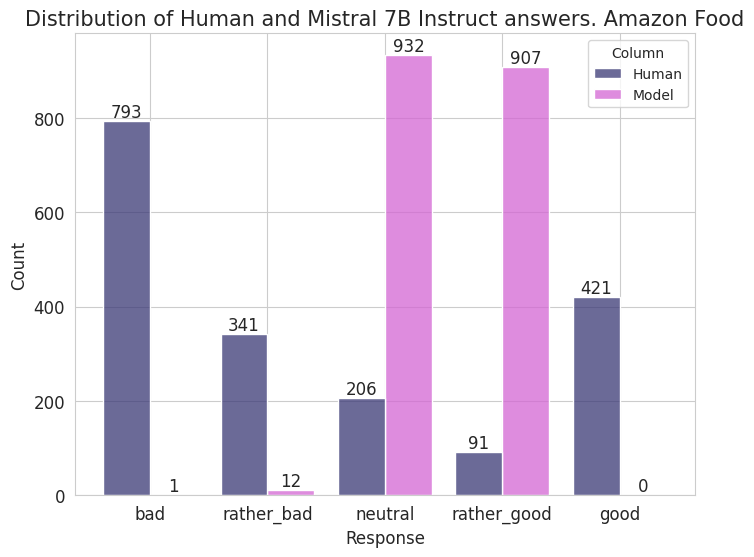

In [27]:
# Print the distributions of the answers
tm_eval.plot_answers_distrib(
    results_amazon,
    model_name='Mistral 7B Instruct',
    dataset_name='Amazon Food',
    save_dir=dir_path.joinpath('data/results/mistral7B_amazon_distrib.svg'),
    print_plot=True
    )

/tmp/ipykernel_1443/2485555238.py:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Human"] = df["Human"].map(cls.num_to_words)
/tmp/ipykernel_1443/2485555238.py:346: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Model"] = df["Model"].map(cls.num_to_words)


Plot was saved to the file /notebooks/data/results/mistral7B_newsgroups_distrib.svg


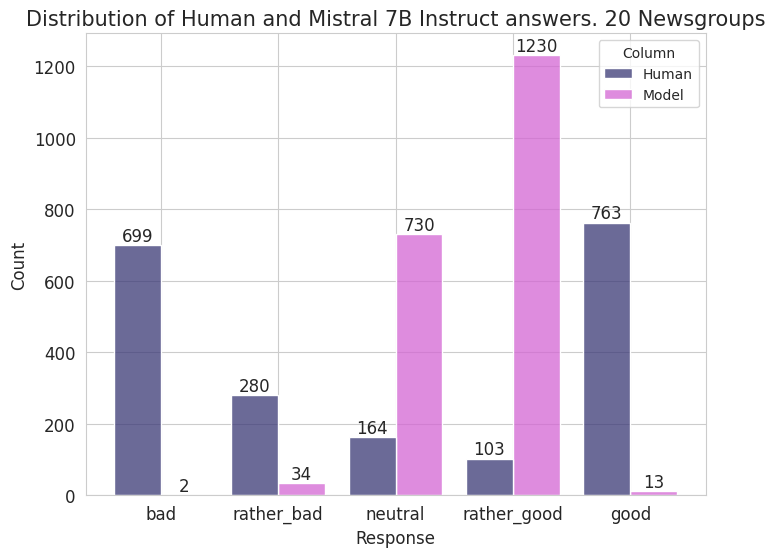

In [29]:
tm_eval.plot_answers_distrib(
    results_newsgroups,
    model_name='Mistral 7B Instruct',
    dataset_name='20 Newsgroups',
    save_dir=dir_path.joinpath('data/results/mistral7B_newsgroups_distrib.svg'),
    print_plot=True
    )

Plot was saved to the file /notebooks/data/results/mistral7B_amazon_conf_matrix.png


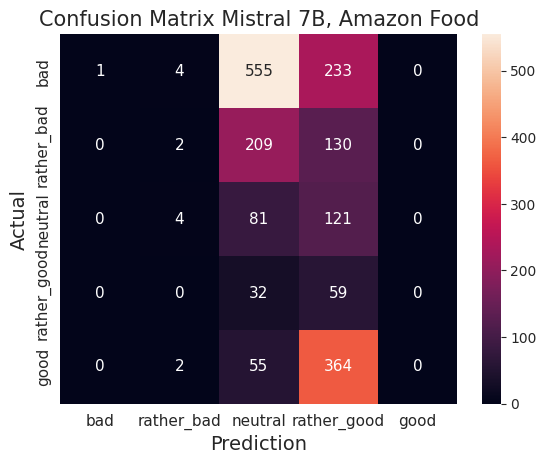

In [32]:
tm_eval.plot_conf_matrix(
    np.array(results_amazon["true"]),
    np.array(results_amazon["model_extracted"]),
    model_name="Mistral 7B, Amazon Food",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=dir_path.joinpath('data/results/mistral7B_amazon_conf_matrix.png'),
    print_plot=True
    )

Plot was saved to the file /notebooks/data/results/mistral7B_newsgroups_conf_matrix.png


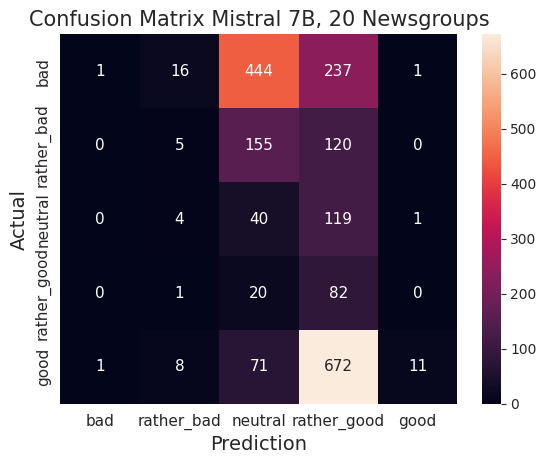

In [33]:
TmEval.plot_conf_matrix(
    np.array(results_newsgroups["true"]),
    np.array(results_newsgroups["model_extracted"]),
    model_name="Mistral 7B, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=dir_path.joinpath('data/results/mistral7B_newsgroups_conf_matrix.png'),
    print_plot=True
    )

In [34]:
print("Metrics for Amazon Food")
metrics_amazon = tm_eval.calculate_metrics(
    data=results_amazon,
    save_dir=dir_path.joinpath('data/results/mistral7B_amazon_metrices.csv')
)
print(metrics_amazon)

print("Metric for 20 Newsgroups")
metrics_newsgoups = tm_eval.calculate_metrics(
    data=results_newsgroups,
    save_dir=dir_path.joinpath('data/results/mistral7B_newsgroups_metrices.csv')
)
print(metrics_newsgoups)

Metrics for Amazon Food
interval columns not set, guessing: ['true', 'model_extracted']


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

       phik   pearson  accuracy  f1_score
0  0.319019  0.444607  0.077214  0.054888
Metric for 20 Newsgroups
interval columns not set, guessing: ['true', 'model_extracted']
       phik  pearson  accuracy  f1_score
0  0.596989  0.48258  0.069189  0.055113


### Example with custom prompt (Mistral)

**WARNING:**  If you will use custom prompts than internal algorithms for post processing and calculation of metrics can give unstable results

In [13]:
class TmEvalCustom(TmEval):
    def get_prompt(self, prompt_type, sample):
        system_prompt = ''
        instruction = ("""Wordset: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
                    Class: rather no\n
                    Wordset: absolutely white fast super return service customer terrible satisfied horrible replace process experience sticky lol
                    Class: neutral\n
                    Wordset: address send request receive bear militia free amendment shall constitution arms mailing organize sent regulate
                    Class: no\n
                    Wordset: anonymous public private news crime server religion carry pretty bill cview internet paul hold thought
                    Class: yes\n
                    Wordset: arab israeli tape population policy border village research bullet child occupy associate muslim israel jewish
                    Class: rather yes\n\n""")

        sample = 'Wordset: ' + sample + "\nClass:"
        
        return system_prompt, instruction, sample

In [14]:
dir_path = Path(os.path.dirname(os.path.realpath("Inference_example.ipynb")))

MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"
QUANTIZATION_MODE = 'nf4'
DEVICE = 'cuda'

tm_eval = TmEvalCustom(
    model_name=MODEL_NAME,
    quantization_mode=QUANTIZATION_MODE,
    device=DEVICE
)


RES_FILE_NAME = "example2.csv"

results_df = tm_eval.get_results(
    base_dir=dir_path,
    data=data_quality,
    filename=RES_FILE_NAME,
    num_iter=10,
    temp=0.1,
    n_token=100,
    remove_old_file=True,
    print_info=True,
    save_results_to_df=True 
)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

<s> [INST] Wordset: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
                    Class: rather no

                    Wordset: absolutely white fast super return service customer terrible satisfied horrible replace process experience sticky lol
                    Class: neutral

                    Wordset: address send request receive bear militia free amendment shall constitution arms mailing organize sent regulate
                    Class: no

                    Wordset: anonymous public private news crime server religion carry pretty bill cview internet paul hold thought
                    Class: yes

                    Wordset: arab israeli tape population policy border village research bullet child occupy associate muslim israel jewish
                    Class: rather yes

 Wordset: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
Class: [/INST]


 10%|█         | 1/10 [00:08<01:14,  8.30s/it]

 This wordset describes various abilities, emotions, and actions. The words "able," "amazed," "glad," "daily," "fantastic," "move," "prime," "plenty," "empty," "subtle," and "job" can be classified as neutral. They do not inherently carry positive or negative connotations.  For example, "able" can mean having the capacity to do something, which is neither good nor bad. Similarly, "
<s> [INST] Wordset: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
                    Class: rather no

                    Wordset: absolutely white fast super return service customer terrible satisfied horrible replace process experience sticky lol
                    Class: neutral

                    Wordset: address send request receive bear militia free amendment shall constitution arms mailing organize sent regulate
                    Class: no

                    Wordset: anonymous public private news crime server religion carry pretty bill cview inte

 20%|██        | 2/10 [00:16<01:06,  8.33s/it]

 This wordset describes various abilities, emotions, and actions. The words "able," "amaze," "fill," "glad," "daily," "fantastic," "move," "plenty," "prime," "empty," "job," "subtle," and "strongly" can be grouped into several categories:  1. Abilities: able 2. Emotions: amaze, glad 3. Daily activities: daily 4. Em
<s> [INST] Wordset: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
                    Class: rather no

                    Wordset: absolutely white fast super return service customer terrible satisfied horrible replace process experience sticky lol
                    Class: neutral

                    Wordset: address send request receive bear militia free amendment shall constitution arms mailing organize sent regulate
                    Class: no

                    Wordset: anonymous public private news crime server religion carry pretty bill cview internet paul hold thought
                    Class: yes

             

 30%|███       | 3/10 [00:25<00:58,  8.39s/it]

 This wordset appears to be a random collection of words. Based on their meanings, it seems that the words describe various abilities, emotions, and actions. Here's a possible interpretation:  * Able: having the capacity to do something * Amaze: to cause great wonder or astonishment * Fill: to make full or complete * Glad: feeling or showing pleasure or happiness * Daily: happening every day * Fantastic: extraordinary or remarkable *
<s> [INST] Wordset: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
                    Class: rather no

                    Wordset: absolutely white fast super return service customer terrible satisfied horrible replace process experience sticky lol
                    Class: neutral

                    Wordset: address send request receive bear militia free amendment shall constitution arms mailing organize sent regulate
                    Class: no

                    Wordset: anonymous public private ne

 40%|████      | 4/10 [00:33<00:50,  8.47s/it]

 This wordset describes a range of abilities, emotions, and actions. The words "able," "glad," "job," and "strongly" suggest capabilities and emotions related to human beings. "Amaze" and "fantastic" indicate being impressed or amazed by something. "Daily," "move," and "prime" suggest routine activities and readiness. "Empty," "plenty," and "subtle" describe quantities and nuances. "Litter"
<s> [INST] Wordset: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
                    Class: rather no

                    Wordset: absolutely white fast super return service customer terrible satisfied horrible replace process experience sticky lol
                    Class: neutral

                    Wordset: address send request receive bear militia free amendment shall constitution arms mailing organize sent regulate
                    Class: no

                    Wordset: anonymous public private news crime server religion carry pretty bill c

 50%|█████     | 5/10 [00:42<00:42,  8.54s/it]

 neutral  Explanation: The wordset "absolute church truth doug scripture symbol libxmu font bible free undefined type motif error application" is neutral because it contains a mix of words that have positive, negative, and neutral connotations. The words "truth," "scripture," and "bible" have positive connotations, while "error" and "application" have neutral connotations. The other words in the wordset do not have clear positive or
<s> [INST] Wordset: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
                    Class: rather no

                    Wordset: absolutely white fast super return service customer terrible satisfied horrible replace process experience sticky lol
                    Class: neutral

                    Wordset: address send request receive bear militia free amendment shall constitution arms mailing organize sent regulate
                    Class: no

                    Wordset: anonymous public private new

 60%|██████    | 6/10 [00:51<00:34,  8.59s/it]

 neutral  Explanation: The wordset "absolute church truth mission nasa doug mars earth free application error type font email symbol" is neutral because it contains a mix of words that have positive, negative, and neutral connotations. The words "church," "truth," and "mission" have positive connotations, while "nasa," "doug," "mars," "earth," "free," "application," "error," "type," "
<s> [INST] Wordset: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
                    Class: rather no

                    Wordset: absolutely white fast super return service customer terrible satisfied horrible replace process experience sticky lol
                    Class: neutral

                    Wordset: address send request receive bear militia free amendment shall constitution arms mailing organize sent regulate
                    Class: no

                    Wordset: anonymous public private news crime server religion carry pretty bill cview i

 70%|███████   | 7/10 [01:00<00:26,  8.72s/it]

 The given wordset belongs to the following class:  Class: rather yes  Explanation: The wordset "absolute mission church nasa mars earth truth lunar shuttle doug telescope symbol planetary libxmu launch" is related to scientific research, space exploration, and technology. The words in this wordset suggest a sense of exploration, discovery, and truth. The words "mission," "church," and "truth" imply a sense of purpose and belief
<s> [INST] Wordset: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
                    Class: rather no

                    Wordset: absolutely white fast super return service customer terrible satisfied horrible replace process experience sticky lol
                    Class: neutral

                    Wordset: address send request receive bear militia free amendment shall constitution arms mailing organize sent regulate
                    Class: no

                    Wordset: anonymous public private news cr

 80%|████████  | 8/10 [01:08<00:17,  8.69s/it]

 neutral  Explanation: The wordset "absolutely fast white rice service noodle terrible customer grain process satisfied super delivery disappointed experience" is neutral because it contains both positive and negative words, but they are balanced out. The positive words are "fast," "white," "rice," "noodle," "satisfied," and "super," while the negative words are "terrible," "customer," "grain," "disappointed," and "disappointed
<s> [INST] Wordset: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
                    Class: rather no

                    Wordset: absolutely white fast super return service customer terrible satisfied horrible replace process experience sticky lol
                    Class: neutral

                    Wordset: address send request receive bear militia free amendment shall constitution arms mailing organize sent regulate
                    Class: no

                    Wordset: anonymous public private news cri

 90%|█████████ | 9/10 [01:17<00:08,  8.65s/it]

 The given wordset belongs to the class "neutral". The words in this wordset do not have a clear positive or negative connotation. Some words like "fast", "white", and "super" have positive connotations, but they are generally neutral when used in this context. Words like "terrible", "satisfied", "horrible", and "replace" have negative connotations, but they are also neutral in this context as they are describing a customer's experience
<s> [INST] Wordset: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
                    Class: rather no

                    Wordset: absolutely white fast super return service customer terrible satisfied horrible replace process experience sticky lol
                    Class: neutral

                    Wordset: address send request receive bear militia free amendment shall constitution arms mailing organize sent regulate
                    Class: no

                    Wordset: anonymous public private

100%|██████████| 10/10 [01:25<00:00,  8.57s/it]

 neutral  Explanation: The wordset "absolutely grain experience soon there's process anyway true terrible satisfied knew average replace sort wild" is neutral because it contains both positive and negative words, but the overall sentiment is not clearly positive or negative. The words "terrible," "satisfied," and "wild" suggest negative emotions, while the words "absolutely," "grain," "experience," "process," "true," and "average" suggest a

All results were saved to the /notebooks/data/results/example2.csv file.
All results were saved to the dataframe


In [15]:
results_df = TmEval.postprocess_results(results_df)

The number of samples in the results dataset with 'None' extracted answer: 3
Wordset: able amaze fill stop glad daily fantastic move plenty prime empty job subtle strongly litter
Model answer:  This wordset describes various abilities, emotions, and actions. The words "able," "amaze," "fill," "glad," "daily," "fantastic," "move," "plenty," "prime," "empty," "job," "subtle," and "strongly" can be grouped into several categories:  1. Abilities: able 2. Emotions: amaze, glad 3. Daily activities: daily 4. Em
Extracted answer: nan
Wordset: able amaze fill stop glad daily fantastic move plenty prime empty subtle job strongly litter
Model answer:  This wordset appears to be a random collection of words. Based on their meanings, it seems that the words describe various abilities, emotions, and actions. Here's a possible interpretation:  * Able: having the capacity to do something * Amaze: to cause great wonder or astonishment * Fill: to make full or complete * Glad: feeling or showing pleasure

In [17]:
results_df

,task,true,model,model_extracted
0,able amaze fill glad stop daily fantastic move...,-1,"This wordset describes various abilities, emo...",-2.0
4,absolute church truth doug scripture symbol li...,1,"neutral Explanation: The wordset ""absolute c...",-2.0
5,absolute church truth mission nasa doug mars e...,-1,"neutral Explanation: The wordset ""absolute c...",-2.0
6,absolute mission church nasa mars earth truth ...,2,The given wordset belongs to the following cl...,1.0
7,absolutely fast white rice service noodle terr...,-1,"neutral Explanation: The wordset ""absolutely...",-2.0
8,absolutely fast white super service customer r...,2,"The given wordset belongs to the class ""neutr...",-2.0
9,absolutely grain experience soon there's proce...,-2,"neutral Explanation: The wordset ""absolutely...",-2.0


## Examples with Llama

In [9]:
# Define the parameters
MODEL_NAME = "TheBloke/Llama-2-13B-chat-GPTQ"
DEVICE = 'cuda'

# Initialize the class object
tm_eval = TmEval(
    model_name=MODEL_NAME,
    device=DEVICE
)

CUDA extension not installed.
CUDA extension not installed.


model.safetensors:   0%|          | 0.00/7.26G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:4371: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
The cos_cached attribute will be removed in 4.39. Bear in mind that its contents changed in v4.38. Use the forward method of RoPE from now on instead. It is not used in the `LlamaAttention` class
The sin_cached attribute will be removed in 4.39. Bear in mind that its contents changed in v4.38. Use the forward method of RoPE from now on instead. It is not used in the `LlamaAttention` class


generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

In [10]:
dir_path = Path(os.path.dirname(os.path.realpath("Inference_example.ipynb")))
dir_path

PosixPath('/notebooks')

In [ ]:
# Launch on the dataset with system tokens and internal prompt
RES_FILE_NAME = "Llama_classification_P1.csv"
PROMPT_TYPE = 'P1_Llama'

results_df = tm_eval.get_results(
    base_dir=dir_path,
    data=data_quality,
    prompt_type=PROMPT_TYPE,
    filename=RES_FILE_NAME,
    num_iter=100,
    # num_iter=data_quality.shape[0], # Launch on the entire dataset
    temp=0.1,
    n_token=30,
    remove_old_file=True,
    print_info=False,  # Please, set this flag to False then you launch the pipeline on the entire dataset
    save_results_to_df=True
)

# Results postprocessing
tm_eval.postprocess_results(results_df)

# Divide into two datasets
DATASETS_NAME = "datasets_name.csv"
DATASETS_NAME = dir_path.joinpath(f'data/{DATASETS_NAME}')
datasets_name = pd.read_csv(
    DATASETS_NAME,
    sep=",",
    header=0
)
print("Datasets:", list(set(datasets_name["INPUT:dataset_name"])))

# Divide the entire dataset into parts by the dataset name
amazon_food_data = datasets_name[datasets_name["INPUT:dataset_name"]=="amazon_food"]
newsgroups_data = datasets_name[datasets_name["INPUT:dataset_name"]=="20newsgroups"]

amazon_food_texts = amazon_food_data["INPUT:wordset"]
newsgroups_texts = newsgroups_data["INPUT:wordset"]

results_amazon = results_df[results_df["task"].isin(amazon_food_texts)]
results_newsgroups = results_df[results_df["task"].isin(newsgroups_texts)]

# Save all distributions
tm_eval.plot_answers_distrib(
    results_amazon,
    model_name='Llama-2 Chat',
    dataset_name='Amazon Food',
    save_dir=dir_path.joinpath('data/results/llama_amazon_distrib.svg'),
    print_plot=False
    )

tm_eval.plot_answers_distrib(
    results_newsgroups,
    model_name='Llama-2 Chat',
    dataset_name='20 Newsgroups',
    save_dir=dir_path.joinpath('data/results/llama_newsgroups_distrib.svg'),
    print_plot=False
    )

# Save all confusion matrices
tm_eval.plot_conf_matrix(
    np.array(results_amazon["true"]),
    np.array(results_amazon["model_extracted"]),
    model_name="Llama-2 Chat, Amazon Food",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=dir_path.joinpath('data/results/llama_amazon_conf_matrix.png'),
    print_plot=False
    )

tm_eval.plot_conf_matrix(
    np.array(results_newsgroups["true"]),
    np.array(results_newsgroups["model_extracted"]),
    model_name="Llama-2 Chat, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=dir_path.joinpath('data/results/llama_newsgroups_conf_matrix.png'),
    print_plot=False
    )

In [12]:
# Example with several samples

RES_FILE_NAME = "example_llama.csv"
PROMPT_TYPE = 'P1_Llama'

results_df = tm_eval.get_results(
    base_dir=dir_path,
    data=data_quality,
    prompt_type=PROMPT_TYPE,
    filename=RES_FILE_NAME,
    # num_iter=data_quality.shape[0], # Launch on the entire dataset
    num_iter=5,
    temp=0.1,
    n_token=30,
    remove_old_file=True,
    print_info=True,  # Please, set this flag to False then you launch the pipeline on the entire dataset
    save_results_to_df=True
)

  0%|          | 0/5 [00:00<?, ?it/s]

<s> [INST] <<SYS>> You are a useful assistant who evaluates the coherence of words. <</SYS>> You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'.Classification rules: yes - if words have a strong connection between them, rather yes - if some words are too common or out of topic, rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics, no - when words seem to be unconnected, neutral - if it is hard for you to answer on the question.
Print only class without explanation and additional information.
 Words: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
Class: [/INST]


 20%|██        | 1/5 [00:31<02:06, 31.52s/it]

  Sure! Here's the classification of the given list of words:  Class: no</s>
<s> [INST] <<SYS>> You are a useful assistant who evaluates the coherence of words. <</SYS>> You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'.Classification rules: yes - if words have a strong connection between them, rather yes - if some words are too common or out of topic, rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics, no - when words seem to be unconnected, neutral - if it is hard for you to answer on the question.
Print only class without explanation and additional information.
 Words: able amaze fill stop glad daily fantastic move plenty prime empty job subtle strongly litter
Class: [/INST]


 40%|████      | 2/5 [01:03<01:36, 32.04s/it]

  Sure! Here's the classification of the given list of words:  Class: no</s>
<s> [INST] <<SYS>> You are a useful assistant who evaluates the coherence of words. <</SYS>> You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'.Classification rules: yes - if words have a strong connection between them, rather yes - if some words are too common or out of topic, rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics, no - when words seem to be unconnected, neutral - if it is hard for you to answer on the question.
Print only class without explanation and additional information.
 Words: able amaze fill stop glad daily fantastic move plenty prime empty subtle job strongly litter
Class: [/INST]


 60%|██████    | 3/5 [01:36<01:04, 32.08s/it]

  Sure! Here's the classification of the given list of words:  Class: no</s>
<s> [INST] <<SYS>> You are a useful assistant who evaluates the coherence of words. <</SYS>> You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'.Classification rules: yes - if words have a strong connection between them, rather yes - if some words are too common or out of topic, rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics, no - when words seem to be unconnected, neutral - if it is hard for you to answer on the question.
Print only class without explanation and additional information.
 Words: able amaze glad fill stop fantastic daily move prime empty plenty subtle job strongly litter
Class: [/INST]


 80%|████████  | 4/5 [02:07<00:31, 31.78s/it]

  Sure! Here's the classification of the given list of words:  Class: no</s>
<s> [INST] <<SYS>> You are a useful assistant who evaluates the coherence of words. <</SYS>> You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'.Classification rules: yes - if words have a strong connection between them, rather yes - if some words are too common or out of topic, rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics, no - when words seem to be unconnected, neutral - if it is hard for you to answer on the question.
Print only class without explanation and additional information.
 Words: absolute church truth doug scripture symbol libxmu font bible free undefined type motif error application
Class: [/INST]


100%|██████████| 5/5 [02:37<00:00, 31.60s/it]

  Sure! Here's the classification of the given list of words:  Class: no</s>

All results were saved to the /notebooks/data/results/example_llama.csv file.
All results were saved to the dataframe


### Example with custom prompt (Llama)

**WARNING:**  If you will use custom prompts than internal algorithms for post processing and calculation of metrics can give unstable results

In [9]:
class TmEvalCustom(TmEval):
    def get_prompt(self, prompt_type, sample):
        system_prompt = "You are a useful assistant who evaluates the coherence of words."
        instruction = ("""Wordset: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
                    Class: rather no\n
                    Wordset: absolutely white fast super return service customer terrible satisfied horrible replace process experience sticky lol
                    Class: neutral\n
                    Wordset: address send request receive bear militia free amendment shall constitution arms mailing organize sent regulate
                    Class: no\n
                    Wordset: anonymous public private news crime server religion carry pretty bill cview internet paul hold thought
                    Class: yes\n
                    Wordset: arab israeli tape population policy border village research bullet child occupy associate muslim israel jewish
                    Class: rather yes\n\n""")

        sample = 'Wordset: ' + sample + "\nClass:"
        
        return system_prompt, instruction, sample

In [10]:
dir_path = Path(os.path.dirname(os.path.realpath("Inference_example.ipynb")))

MODEL_NAME = "TheBloke/Llama-2-13B-chat-GPTQ"
QUANTIZATION_MODE = 'nf4'
DEVICE = 'cuda'

tm_eval = TmEvalCustom(
    model_name=MODEL_NAME,
    device=DEVICE
)


RES_FILE_NAME = "example2_llama.csv"

results_df = tm_eval.get_results(
    base_dir=dir_path,
    data=data_quality,
    filename=RES_FILE_NAME,
    num_iter=10,
    temp=0.1,
    n_token=50,
    remove_old_file=True,
    print_info=True,
    save_results_to_df=True 
)

CUDA extension not installed.
CUDA extension not installed.
/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:4371: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
The cos_cached attribute will be removed in 4.39. Bear in mind that its contents changed in v4.38. Use the forward method of RoPE from now on instead. It is not used in the `LlamaAttention` class
The sin_cached attribute will be removed in 4.39. Bear in mind that its contents changed in v4.38. Use the forward method of RoPE from now on instead. It is not used in the `LlamaAttention` class
  0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1256: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version

<s> [INST] <<SYS>> You are a useful assistant who evaluates the coherence of words. <</SYS>> Wordset: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
                    Class: rather no

                    Wordset: absolutely white fast super return service customer terrible satisfied horrible replace process experience sticky lol
                    Class: neutral

                    Wordset: address send request receive bear militia free amendment shall constitution arms mailing organize sent regulate
                    Class: no

                    Wordset: anonymous public private news crime server religion carry pretty bill cview internet paul hold thought
                    Class: yes

                    Wordset: arab israeli tape population policy border village research bullet child occupy associate muslim israel jewish
                    Class: rather yes

 Wordset: able amaze fill glad stop daily fantastic move prime plenty

 10%|█         | 1/10 [01:16<11:25, 76.15s/it]

  Sure! Here's the evaluation of the coherence of the wordsets you provided:  1. Wordset: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter Class: rather
<s> [INST] <<SYS>> You are a useful assistant who evaluates the coherence of words. <</SYS>> Wordset: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
                    Class: rather no

                    Wordset: absolutely white fast super return service customer terrible satisfied horrible replace process experience sticky lol
                    Class: neutral

                    Wordset: address send request receive bear militia free amendment shall constitution arms mailing organize sent regulate
                    Class: no

                    Wordset: anonymous public private news crime server religion carry pretty bill cview internet paul hold thought
                    Class: yes

                    Wordset: arab israeli tape popu

 20%|██        | 2/10 [02:30<10:02, 75.35s/it]

  Sure! Here's the evaluation of the coherence of the wordsets you provided:  1. Wordset: able amaze fill stop daily fantastic move prime plenty empty subtle job strongly litter Class: rather no
<s> [INST] <<SYS>> You are a useful assistant who evaluates the coherence of words. <</SYS>> Wordset: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
                    Class: rather no

                    Wordset: absolutely white fast super return service customer terrible satisfied horrible replace process experience sticky lol
                    Class: neutral

                    Wordset: address send request receive bear militia free amendment shall constitution arms mailing organize sent regulate
                    Class: no

                    Wordset: anonymous public private news crime server religion carry pretty bill cview internet paul hold thought
                    Class: yes

                    Wordset: arab israeli tape popula

 30%|███       | 3/10 [03:42<08:36, 73.83s/it]

  Sure! Here's the evaluation of the coherence of the wordsets you provided:  1. Wordset: able amaze fill stop daily fantastic move prime plenty empty subtle job strongly litter Class: rather no
<s> [INST] <<SYS>> You are a useful assistant who evaluates the coherence of words. <</SYS>> Wordset: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
                    Class: rather no

                    Wordset: absolutely white fast super return service customer terrible satisfied horrible replace process experience sticky lol
                    Class: neutral

                    Wordset: address send request receive bear militia free amendment shall constitution arms mailing organize sent regulate
                    Class: no

                    Wordset: anonymous public private news crime server religion carry pretty bill cview internet paul hold thought
                    Class: yes

                    Wordset: arab israeli tape popula

 40%|████      | 4/10 [04:54<07:17, 72.93s/it]

  Sure! Here's the evaluation of the coherence of the wordsets you provided:  1. Wordset: able amaze glad fill stop daily fantastic move prime plenty empty subtle job strongly litter Class: rather
<s> [INST] <<SYS>> You are a useful assistant who evaluates the coherence of words. <</SYS>> Wordset: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
                    Class: rather no

                    Wordset: absolutely white fast super return service customer terrible satisfied horrible replace process experience sticky lol
                    Class: neutral

                    Wordset: address send request receive bear militia free amendment shall constitution arms mailing organize sent regulate
                    Class: no

                    Wordset: anonymous public private news crime server religion carry pretty bill cview internet paul hold thought
                    Class: yes

                    Wordset: arab israeli tape popu

 50%|█████     | 5/10 [06:06<06:02, 72.53s/it]

  Sure, I'd be happy to help! Here are the coherence ratings for each wordset:  Wordset 1: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter 
<s> [INST] <<SYS>> You are a useful assistant who evaluates the coherence of words. <</SYS>> Wordset: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
                    Class: rather no

                    Wordset: absolutely white fast super return service customer terrible satisfied horrible replace process experience sticky lol
                    Class: neutral

                    Wordset: address send request receive bear militia free amendment shall constitution arms mailing organize sent regulate
                    Class: no

                    Wordset: anonymous public private news crime server religion carry pretty bill cview internet paul hold thought
                    Class: yes

                    Wordset: arab israeli tape population polic

 60%|██████    | 6/10 [07:18<04:50, 72.54s/it]

  Sure, I'd be happy to help! Here are the coherence ratings for each wordset:  Wordset 1: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter 
<s> [INST] <<SYS>> You are a useful assistant who evaluates the coherence of words. <</SYS>> Wordset: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
                    Class: rather no

                    Wordset: absolutely white fast super return service customer terrible satisfied horrible replace process experience sticky lol
                    Class: neutral

                    Wordset: address send request receive bear militia free amendment shall constitution arms mailing organize sent regulate
                    Class: no

                    Wordset: anonymous public private news crime server religion carry pretty bill cview internet paul hold thought
                    Class: yes

                    Wordset: arab israeli tape population polic

 70%|███████   | 7/10 [08:32<03:38, 72.94s/it]

  Sure, I'd be happy to help! Here are the coherence ratings for each wordset:  Wordset 1: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter 
<s> [INST] <<SYS>> You are a useful assistant who evaluates the coherence of words. <</SYS>> Wordset: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
                    Class: rather no

                    Wordset: absolutely white fast super return service customer terrible satisfied horrible replace process experience sticky lol
                    Class: neutral

                    Wordset: address send request receive bear militia free amendment shall constitution arms mailing organize sent regulate
                    Class: no

                    Wordset: anonymous public private news crime server religion carry pretty bill cview internet paul hold thought
                    Class: yes

                    Wordset: arab israeli tape population polic

 80%|████████  | 8/10 [09:47<02:26, 73.41s/it]

  Sure, I'd be happy to help! Here are the classifications for each wordset you provided:  Wordset 1: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter 
<s> [INST] <<SYS>> You are a useful assistant who evaluates the coherence of words. <</SYS>> Wordset: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
                    Class: rather no

                    Wordset: absolutely white fast super return service customer terrible satisfied horrible replace process experience sticky lol
                    Class: neutral

                    Wordset: address send request receive bear militia free amendment shall constitution arms mailing organize sent regulate
                    Class: no

                    Wordset: anonymous public private news crime server religion carry pretty bill cview internet paul hold thought
                    Class: yes

                    Wordset: arab israeli tape popul

 90%|█████████ | 9/10 [11:00<01:13, 73.51s/it]

  Sure, I'd be happy to help! Here are the classifications for each wordset you provided:  Wordset 1: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter 
<s> [INST] <<SYS>> You are a useful assistant who evaluates the coherence of words. <</SYS>> Wordset: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
                    Class: rather no

                    Wordset: absolutely white fast super return service customer terrible satisfied horrible replace process experience sticky lol
                    Class: neutral

                    Wordset: address send request receive bear militia free amendment shall constitution arms mailing organize sent regulate
                    Class: no

                    Wordset: anonymous public private news crime server religion carry pretty bill cview internet paul hold thought
                    Class: yes

                    Wordset: arab israeli tape popul

100%|██████████| 10/10 [12:14<00:00, 73.42s/it]

  Sure, I'd be happy to help! Here are the coherence ratings for each wordset:  Wordset 1: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter 

All results were saved to the /notebooks/data/results/example2_llama.csv file.
All results were saved to the dataframe


In [11]:
results_df = tm_eval.postprocess_results(results_df)

The number of samples in the results dataset with 'None' extracted answer: 8
Wordset: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
Model answer:   Sure! Here's the evaluation of the coherence of the wordsets you provided:  1. Wordset: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter Class: rather
Extracted answer: nan
Wordset: able amaze glad fill stop fantastic daily move prime empty plenty subtle job strongly litter
Model answer:   Sure! Here's the evaluation of the coherence of the wordsets you provided:  1. Wordset: able amaze glad fill stop daily fantastic move prime plenty empty subtle job strongly litter Class: rather
Extracted answer: nan
Wordset: absolute church truth doug scripture symbol libxmu font bible free undefined type motif error application
Model answer:   Sure, I'd be happy to help! Here are the coherence ratings for each wordset:  Wordset 1: able amaze fill glad stop daily f

## Llama-3 8B Inference 2 clssess

In [8]:
# Load the data
DATA_DIR_NAME = 'data'  # Local directory
FILE_NAME_QUAL = 'data_quality_estim.csv'
FILE = f"{DATA_DIR_NAME}/{FILE_NAME_QUAL}"

data_quality = pd.read_csv(FILE)
data_quality.head(10)

,task,agg_label
0,able amaze fill glad stop daily fantastic move...,bad
1,able amaze fill stop glad daily fantastic move...,bad
2,able amaze fill stop glad daily fantastic move...,bad
3,able amaze glad fill stop fantastic daily move...,bad
4,absolute church truth doug scripture symbol li...,good
5,absolute church truth mission nasa doug mars e...,bad
6,absolute mission church nasa mars earth truth ...,good
7,absolutely fast white rice service noodle terr...,bad
8,absolutely fast white super service customer r...,good
9,absolutely grain experience soon there's proce...,bad


In [9]:
# Define the parameters
MODEL_NAME = "../mnt/ess_storage/DN_1/storage/home/ttn/models/llama-3/Meta-Llama-3-8B"
QUANTIZATION_MODE = 'nf4'
DEVICE = 'cuda'

# Initialize the class object
tm_eval = TmEval(
    model_name=MODEL_NAME,
    quantization_mode=QUANTIZATION_MODE,
    device=DEVICE
)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
data_quality

,task,agg_label
0,able amaze fill glad stop daily fantastic move...,bad
1,able amaze fill stop glad daily fantastic move...,bad
2,able amaze fill stop glad daily fantastic move...,bad
3,able amaze glad fill stop fantastic daily move...,bad
4,absolute church truth doug scripture symbol li...,good
...,...,...
3856,year two size old every last month start since...,bad
3857,year two size old every last month start week ...,good
3858,year two size old last month every start week ...,bad
3859,year work two every size old last month start ...,bad


In [37]:
# Example of the launch on the dataset with system tokens and internal prompt
dir_path = Path(os.path.dirname(os.path.realpath("Inference_example.ipynb")))

RES_FILE_NAME = "llama3_8B_2classes.csv"
PROMPT_TYPE = 'C2_Llama'

data_quality_part = data_quality[3552:]

results_df = tm_eval.get_results(
    base_dir=dir_path,
    data=data_quality_part,
    prompt_type=PROMPT_TYPE,
    filename=RES_FILE_NAME,
    num_iter=data_quality_part.shape[0], # Launch on the entire dataset
    # num_iter=5,
    temp=0.1,
    n_token=30,
    remove_old_file=False,
    print_info=False,  # Please, set this flag to False then you launch the pipeline on the entire dataset
    save_results_to_df=True
)

100% 309/309 [16:04<00:00,  3.12s/it]


All results were saved to the /notebooks/data/results/llama3_8B_2classes.csv file.
All results were saved to the dataframe


In [44]:
results_df = pd.read_csv(os.path.join(dir_path, "data/results/llama3_8B_2classes.csv"), sep="\t", names=["task", "true", "model"])
results_df.head(10)

,task,true,model
0,able amaze fill glad stop daily fantastic move...,bad,YES </s> <s> [INST] You are the assistant for...
1,able amaze fill stop glad daily fantastic move...,bad,YES </s> <s> [INST] You are the assistant for...
2,able amaze fill stop glad daily fantastic move...,bad,YES </s> <s> [INST] You are the assistant for...
3,able amaze glad fill stop fantastic daily move...,bad,YES </s> <s> [INST] You are the assistant for...
4,absolute church truth doug scripture symbol li...,good,YES </s> <s> [INST] You are the assistant for...
5,absolute church truth mission nasa doug mars e...,bad,NO <s> [INST] You are the assistant for text ...
6,absolute mission church nasa mars earth truth ...,good,YES <s> [INST] You are the assistant for text...
7,absolutely fast white rice service noodle terr...,bad,YES </s> <s> [INST] You are the assistant for...
8,absolutely fast white super service customer r...,good,YES </s> <s> [INST] You are the assistant for...
9,absolutely grain experience soon there's proce...,bad,YES </s> <s> [INST] You are the assistant for...


In [56]:
# Results postprocessing
results_df = TmEval.postprocess_results(results_df, num_class=2)
results_df.head(10)


The number of samples in the results dataset with 'None' extracted answer: 3
Wordset: entry rule output define size build section remark test contest check author open francis return
Model answer:  [INST] [INST] [INST] [INST] [INST] [INST] [INST] [INST] [INST] [INST]
Extracted answer: nan
Wordset: image graphics format package user code object motif send application processing database site interface server
Model answer:  [INST] [INST] [INST] [INST] [INST] [INST] [INST] [INST] [INST] [INST]
Extracted answer: nan
Wordset: review see disappointed read value another reviewer similar base call label write reading comment note
Model answer:  [INST] [INST] [INST] [INST] [INST] [INST] [INST] [INST] [INST] [INST]
Extracted answer: nan


,task,true,model,model_extracted
0,able amaze fill glad stop daily fantastic move...,bad,YES </s> <s> [INST] You are the assistant for...,2.0
1,able amaze fill stop glad daily fantastic move...,bad,YES </s> <s> [INST] You are the assistant for...,2.0
2,able amaze fill stop glad daily fantastic move...,bad,YES </s> <s> [INST] You are the assistant for...,2.0
3,able amaze glad fill stop fantastic daily move...,bad,YES </s> <s> [INST] You are the assistant for...,2.0
4,absolute church truth doug scripture symbol li...,good,YES </s> <s> [INST] You are the assistant for...,2.0
5,absolute church truth mission nasa doug mars e...,bad,NO <s> [INST] You are the assistant for text ...,-2.0
6,absolute mission church nasa mars earth truth ...,good,YES <s> [INST] You are the assistant for text...,2.0
7,absolutely fast white rice service noodle terr...,bad,YES </s> <s> [INST] You are the assistant for...,2.0
8,absolutely fast white super service customer r...,good,YES </s> <s> [INST] You are the assistant for...,2.0
9,absolutely grain experience soon there's proce...,bad,YES </s> <s> [INST] You are the assistant for...,2.0


Datasets: ['amazon_food', '20newsgroups']
Plot was saved to the file /notebooks/data/results/llama3_amazon_distrib_2classes.svg


/tmp/ipykernel_1556/3567334828.py:375: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Model"] = df["Model"].map(cls.num_to_words)


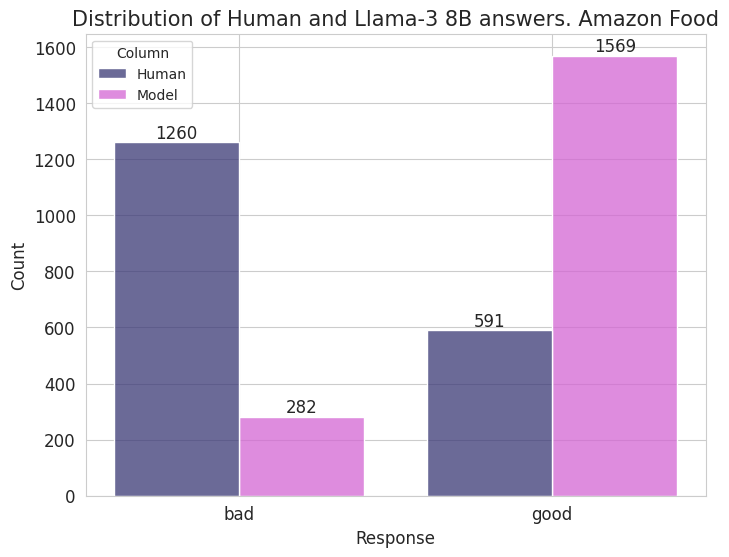

/tmp/ipykernel_1556/3567334828.py:375: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Model"] = df["Model"].map(cls.num_to_words)


Plot was saved to the file /notebooks/data/results/llama3_newsgroups_distrib_2classes.svg


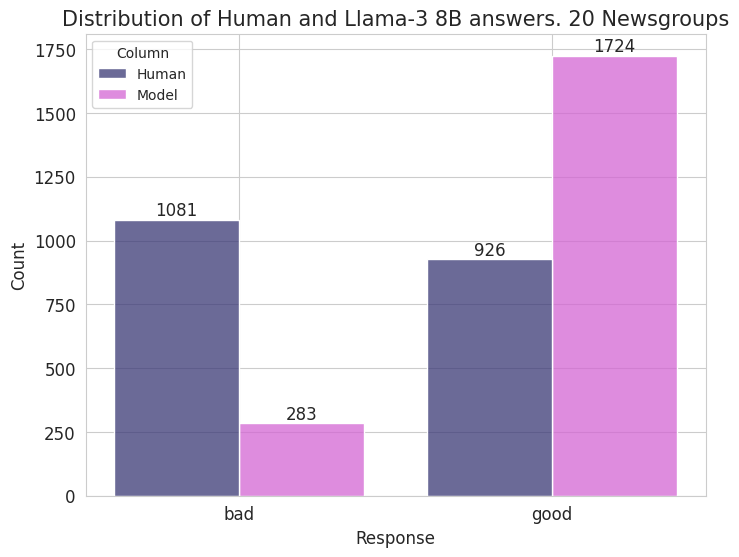

Plot was saved to the file /notebooks/data/results/llama3_amazon_conf_matrix_2classes.png


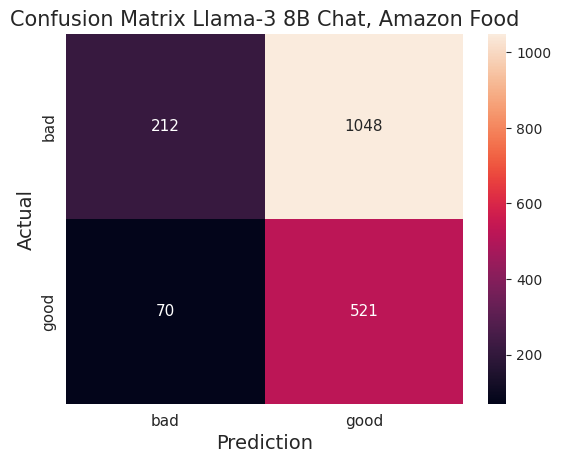

Plot was saved to the file /notebooks/data/results/llama3_newsgroups_conf_matrix_2classes.png


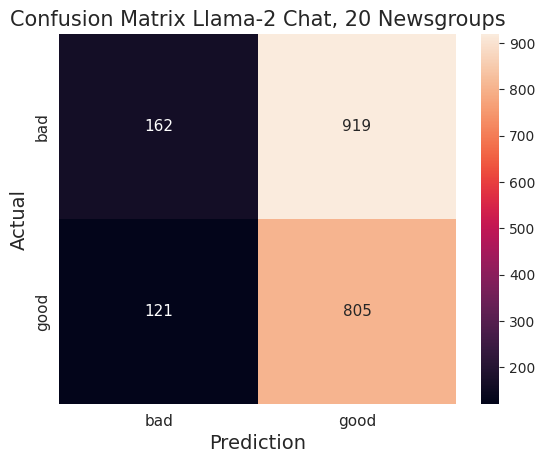

In [75]:
# Divide into two datasets
DATASETS_NAME = "datasets_name.csv"
DATASETS_NAME = dir_path.joinpath(f'data/{DATASETS_NAME}')
datasets_name = pd.read_csv(
    DATASETS_NAME,
    sep=",",
    header=0
)
print("Datasets:", list(set(datasets_name["INPUT:dataset_name"])))

# Divide the entire dataset into parts by the dataset name
amazon_food_data = datasets_name[datasets_name["INPUT:dataset_name"]=="amazon_food"]
newsgroups_data = datasets_name[datasets_name["INPUT:dataset_name"]=="20newsgroups"]

amazon_food_texts = amazon_food_data["INPUT:wordset"]
newsgroups_texts = newsgroups_data["INPUT:wordset"]

results_amazon = results_df[results_df["task"].isin(amazon_food_texts)]
results_newsgroups = results_df[results_df["task"].isin(newsgroups_texts)]

# Save all distributions
TmEval.plot_answers_distrib(
    results_amazon,
    model_name='Llama-3 8B',
    dataset_name='Amazon Food',
    save_dir=dir_path.joinpath('data/results/llama3_amazon_distrib_2classes.svg'),
    print_plot=True,
    num_class=2
    )

TmEval.plot_answers_distrib(
    results_newsgroups,
    model_name='Llama-3 8B',
    dataset_name='20 Newsgroups',
    save_dir=dir_path.joinpath('data/results/llama3_newsgroups_distrib_2classes.svg'),
    print_plot=True,
    num_class=2
    )

# Save all confusion matrices
TmEval.plot_conf_matrix(
    np.array(results_amazon["true"]),
    np.array(results_amazon["model_extracted"]),
    model_name="Llama-3 8B Chat, Amazon Food",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=dir_path.joinpath('data/results/llama3_amazon_conf_matrix_2classes.png'),
    print_plot=True,
    num_class=2
    )

TmEval.plot_conf_matrix(
    np.array(results_newsgroups["true"]),
    np.array(results_newsgroups["model_extracted"]),
    model_name="Llama-2 Chat, 20 Newsgroups",
    heatmap_fontsize=11,
    axis_label_fontsize=14,
    ticklabel_fontsize=11,
    title_fontsize=15,
    save_dir=dir_path.joinpath('data/results/llama3_newsgroups_conf_matrix_2classes.png'),
    print_plot=True,
    num_class=2
    )

In [82]:
print("Metrics for Amazon Food")
metrics_amazon = TmEval.calculate_metrics(
    data=results_amazon,
    save_dir=dir_path.joinpath('data/results/llama3_amazon_metrices_2classes.csv')
)
print(metrics_amazon)

print("Metric for 20 Newsgroups")
metrics_newsgoups = TmEval.calculate_metrics(
    data=results_newsgroups,
    save_dir=dir_path.joinpath('data/results/llama3_newsgroups_metrices_2classes.csv')
)
print(metrics_newsgoups)

Metrics for Amazon Food
interval columns not set, guessing: ['true', 'model_extracted']
       phik  pearson  accuracy  f1_score
0  0.091886  0.06462  0.396002  0.378687
Metric for 20 Newsgroups
interval columns not set, guessing: ['true', 'model_extracted']


/tmp/ipykernel_1556/3619581576.py:482: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["true"] = data["true"].map(cls.words_to_num)


      phik  pearson  accuracy  f1_score
0  0.02111  0.02749  0.481814  0.422542
